# A really simple example



In [1]:
%matplotlib inline
# Plot everything as SVG
%config InlineBackend.figure_formats=['svg']

# Hide warnings
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We'll use this later to visualize lines
def make_line(m, b, frm=0, to=200):
    xs = np.linspace(frm, to, 500)
    ys = np.dot(xs[:,np.newaxis], [m]) + b
    return xs, ys

In [2]:
# pandas can easily read CSVs into a dataframe
df = pd.read_csv('../data/cow_data.csv')
df.head()

,Birth Weight,Mature Weight
0,50.000000,152.738153
1,51.010101,154.806579
2,52.020202,147.596804
3,53.030303,154.066860
4,54.040404,137.015034


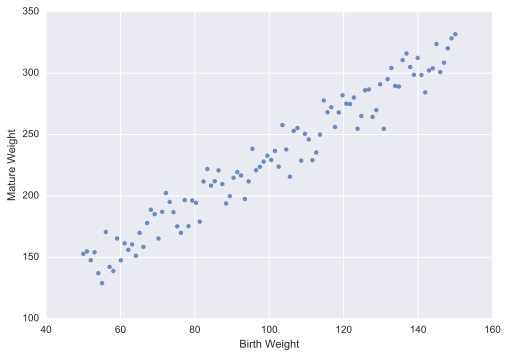

In [21]:
# Let's see what our data looks like
sns.regplot(df['Birth Weight'], df['Mature Weight'], fit_reg=False)

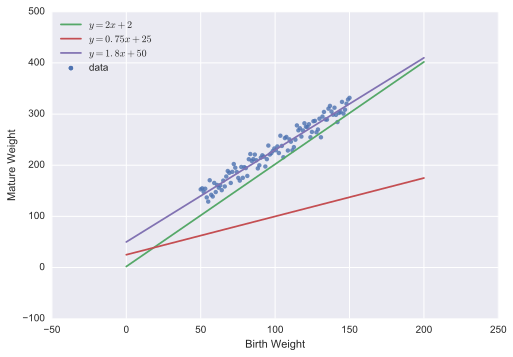

In [26]:
# try manually fitting
sns.regplot(df['Birth Weight'], df['Mature Weight'], fit_reg=False)
xs, ys = make_line(2, 2)
plt.plot(xs, ys)
xs, ys = make_line(0.75, 25)
plt.plot(xs, ys)
xs, ys = make_line(1.8,50)
plt.plot(xs, ys)
plt.legend(['$y=2x + 2$', '$y=0.75x + 25$', '$y=1.8x + 50$', 'data'], loc=2)

In [22]:
# We will use scikit-learn's LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Note the double brackets for X -- this is necessary to get X in the right format/shape
X = df[['Birth Weight']]
y = df['Mature Weight']

# Create the model and "fit" it to the data.
# We'll go into more detail how this works in a little bit.
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
# What value's for m and b did we learn?
m = model.coef_[0]
b = model.intercept_

print('m', m)
print('b', b)

m 1.80435039028
b 50.0953455661


So our algorithm gave us m=1.8,b=50 back and thus we have learned the function:

$$
y = 1.804x + 50.095
$$

for relating a cow's birth weight to its weight at maturity.

This function is called the _hypothesis_, and we can now use it to estimate deer heights given deer weights.

Let's see what this looks like.

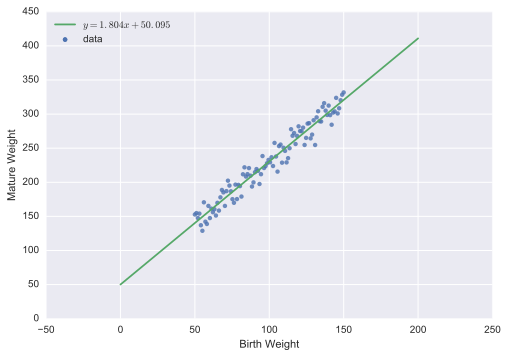

In [24]:
sns.regplot(df['Birth Weight'], df['Mature Weight'], fit_reg=False)
xs, ys = make_line(m,b)
plt.plot(xs, ys)
plt.legend(['$y=1.804x + 50.095$', 'data'], loc=2)

### How wrong you are: Mean Squared Error

One way to do so is to look at the __mean squared error__, which basically looks at how far our predicted points are off from the true points on average, penalizing greater mistakes more.

For instance, if I have the data and the predicted values:

| x | y true | y predicted |
|---|--------|-------------|
| 1 | 2      | 3           |
| 2 | 4      | 9           |
| 3 | 6      | 4           |

The mean squared error here would be:

$$
\frac{(3-2)^2 + (9-4)^2 + (4-6)^2}{3} = \frac{1 + 25 + 4}{3} = 10
$$

In [8]:
y_pred = model.predict(X)
metrics.mean_squared_error(y_pred, y)

146.85759888670108

The line fits the data pretty well.

The function I used to generate the data was:

$$
y = 1.8x + 50
$$

So our linear regression model is very close.

Let's say we have a cow born weighing 150kg. We can use our hypothesis to predict its weight at maturity:

$$
y = 1.804(150) + 50.095
$$

__Important Note__: You normally should not evaluate a model's performance on the data used to train it - if you evaluate this way, the model may _overfit_, that is, start to capture the idiosyncracies of the training data, which may not reflect the more general process you are trying to describe. The best practice is to set aside some of your data for validation and use that to evaluate your model.

### Generalizing models: training & testing

But there's another problem here. We are evaluating our model's performance on the data it has already seen. This gives us an overly optimistic estimate of how well we are doing because the model has already "seen" the correct values for each of these inputs. It won't tell us anything about how well the model __generalizes__, that is, how well it does on _new_ data.

This is a common problem to watch out for in machine learning. You may have very good performance (i.e. lower error) on your training set, but do terrible elsewhere. In that case, it is likely your model is __overfit__, which is to say it fits too tightly to the pecularities of the training set.

![](assets/overfitting.png)
(from [the Shape of Data](https://shapeofdata.files.wordpress.com))

(The opposite of overfitting is underfitting, depicted on the left)

The typical practice here is to divide our data into a separate __training__ and __testing__ set. That way our testing set acts as "new" data the model has not yet seen and you can get a better sense of how it will do on new data.

There are also more sophisticated ways of getting better estimates of generalizability, but we'll stick with this for now.

Let's split our data into 70% training, 30% testing.

In [9]:
from sklearn.cross_validation import train_test_split

# (set random state for the purposes of demonstration)
train, test = train_test_split(df[['Birth Weight', 'Mature Weight']], train_size=0.7, random_state=1000)
X_train = train[['Birth Weight']]
y_train = train['Mature Weight']
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing data
X_test = test[['Birth Weight']]
y_test = test['Mature Weight']
y_pred = model.predict(X_test)
metrics.mean_squared_error(y_pred, y_test)

162.71574432979344

 As you can see, the error is higher now (it won't necessarily be, though). 
 
 ---

# How does learning happen?

How does the algorithm come up with good values of $m$ and $b$?

It varies, but usually via a _cost_ or _objective_ function (often notated $J$).

This tells the algorithm how "wrong" it is with its current guesses for $m$ and $b$ on the training data.

The algorithm iteratively tries different parameters (i.e. different guesses at the underlying function) until it can (approximately) minimize this error. That is, it tries to _optimize_ the parameters (thus the algorithms used for selecting these parameters are called "optimization algorithms").

Different optimization algorithms have different ways of picking new guesses. The most popular one is _gradient descent_, which looks for the direction in which the error is decreasing, and then takes a step in that direction.

If we were just finding $m$, this might look like:

![](../assets/gradient_descent.svg)

If we're finding both $m$ and $b$, this might look like:

![](../assets/gradient_descent_3d.svg)

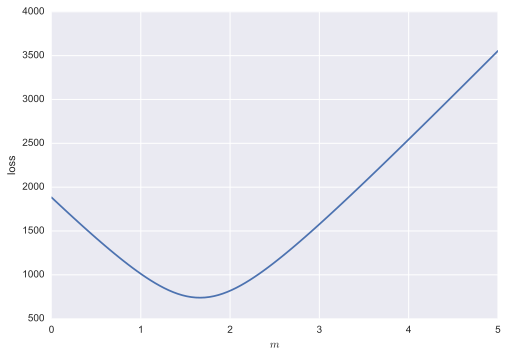

In [10]:
def loss_function(m):
    y_hat = m*X.values + b
    
    # root mean squared error
    return np.sqrt(np.sum((y_hat - y.values)**2)/len(X))

ms = np.linspace(0,5,100)
losses = []
for m in ms:
    losses.append(loss_function(m))
plt.plot(ms, losses)
plt.xlabel('$m$')
plt.ylabel('loss')

# A more complex example

> The __Disposition Matrix__ is a database that United States officials describe as a "next-generation capture/kill list". ... The process determining criteria for killing is not public ([Wikipedia](https://en.wikipedia.org/wiki/Disposition_Matrix))

> Various organizations, including the American Civil Liberties Union, have argued that Sesame Credit is more than just a meme or a game— it’s evidence that the Chinese government is enacting a scheme that will monitor citizens’ finances. More frighteningly, some have suggested, one’s political views or “morality” might raise or lower one’s score. ([Quartz](http://qz.com/519737/all-chinese-citizens-now-have-a-score-based-on-how-well-we-live-and-mine-sucks/))

We could imagine in the near future, if not already, that some of this process is algorithmic. With so many signals out there - your social network activity, quantified-self data, and so on - it may be relatively trivial to automate this process at scale. The Disposition Matrix is an extreme example of the many formulas used to quantify aspects of our lives, such as our eligibility for credit or our cost for insurance and so on.

Just like machine learning can uncover the function behind "natural" relationships like that between a deer's weight and its height, we can use it to "reverse engineer" human-engineered functions as well.


## The Office of Social Health

Imagine future where every citizen is assigned a "crime coefficient" which measures how threatening they are to society. It's sort of like big-data version of _Minority Report_'s precrime.

![](../assets/social_health/safety_in_numbers.sm.jpg)

We are interested in learning how these crime coefficients are computed. Most citizen's crime coefficients are public, but some peoples' are not - most notably, the police and politicians. If we can uncover the formula for computing crime coefficients, may be can we calculate these secret crime coefficients.

And we have other motives too - the crime coefficient may be systematically biased, and it may not, in fact, predict crime at all.

First, let's consider what data is available. As mentioned, citizens can see their own crime coefficient, and we'll assume that we have some way of collecting them.

In our world there are also a variety of publicly-available datapoints.

Through Facebook, we can see an individual's number of friends and their age. Through Facebook we also have access to some "genetic" information by seeing who their relatives are, and we can cross-reference these relatives with public arrest records to see what percent of an individual's relatives have a criminal record.

We also have access to FitBit (or some other quantified-self) data, such as an individuals' average heart rate.

Each of these _features_ - heart rate, criminal relation, number of Facebook friends, age, and income - may be useful in predicting crime coefficients.

In [12]:
data = pd.read_csv('../data/crimecoef.csv')
data.head()

,heart_rate,criminal_relative,friends,age,crime_coef
0,71.352860,0.032889,414.0,43.039801,1.081684
1,49.609125,0.100910,423.0,30.572606,10.182877
2,52.709426,0.041856,417.0,36.024089,1.751955
3,74.092361,0.156625,408.0,55.548839,24.531254
4,75.067936,0.158631,416.0,44.582839,25.163919


In [ ]:
sns.regplot(data['heart_rate'], data['crime_coef'], fit_reg=False)

In [ ]:
sns.regplot(data['criminal_relative'], data['crime_coef'], fit_reg=False)

In [ ]:
sns.regplot(data['age'], data['crime_coef'], fit_reg=False)

In [ ]:
sns.regplot(data['friends'], data['crime_coef'], fit_reg=False)

In [45]:
# Try heart rate
train, test = train_test_split(data, train_size=0.7, random_state=1000)
X_train = train[['heart_rate']]
y_train = train['crime_coef']

model = LinearRegression()
model.fit(X_train, y_train)

X_test = test[['heart_rate']]
y_test = test['crime_coef']
y_pred = model.predict(X_test)
metrics.mean_squared_error(y_pred, y_test)

3886268.5419214349

In [46]:
# Try adding in friends
train, test = train_test_split(data, train_size=0.7, random_state=1000)
X_train = train[['heart_rate', 'friends']]
y_train = train['crime_coef']

model = LinearRegression()
model.fit(X_train, y_train)

X_test = test[['heart_rate', 'friends']]
y_test = test['crime_coef']
y_pred = model.predict(X_test)
metrics.mean_squared_error(y_pred, y_test)

3886803.6328770509

In [47]:
# Try adding in age
train, test = train_test_split(data, train_size=0.7, random_state=1000)
X_train = train[['heart_rate', 'friends', 'age']]
y_train = train['crime_coef']

model = LinearRegression()
model.fit(X_train, y_train)

X_test = test[['heart_rate', 'friends', 'age']]
y_test = test['crime_coef']
y_pred = model.predict(X_test)
metrics.mean_squared_error(y_pred, y_test)

2202.059672600692

In [61]:
# Try adding in criminal relatives
train, test = train_test_split(data, train_size=0.7, random_state=1000)
X_train = train[['heart_rate', 'friends', 'age', 'criminal_relative']]
y_train = train['crime_coef']

model = LinearRegression()
model.fit(X_train, y_train)

X_test = test[['heart_rate', 'friends', 'age', 'criminal_relative']]
y_test = test['crime_coef']
y_pred = model.predict(X_test)
metrics.mean_squared_error(y_pred, y_test)

192.89477419178218

The criminal relative feature seems to be most important. If we look at the coefficients the algorithm learned, we can see this is the case:

In [62]:
model.coef_

array([  2.72816388e-03,   6.40376599e-03,  -1.10602800e-02,
         4.26707805e+02])

Here is a shortcoming of machine learning - the algorithm learns to correlate criminal relatives with criminal activity but does not examine the underlying structural causes (and has no concept of it).